In [1]:
# Importing Libraries
from google.colab import files
import math
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.arima_model as smzs
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
files.upload()

In [3]:
# Loading the data
def load_data(file_path):
    df = pd.read_excel(file_path)
    df.columns = df.columns.str.strip()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    return df

In [4]:
df = load_data("GK Quaterly Stock Prices.xlsx")

In [5]:
df.head()

,Closing Price
Date,
2023-08-24,75.84
2023-08-25,75.66
2023-08-26,75.66
2023-08-27,75.66
2023-08-28,75.87


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 95 entries, 2023-08-24 to 2023-11-26
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Closing Price  95 non-null     float64
dtypes: float64(1)
memory usage: 1.5 KB


In [7]:
print(df.columns)

Index(['Closing Price'], dtype='object')


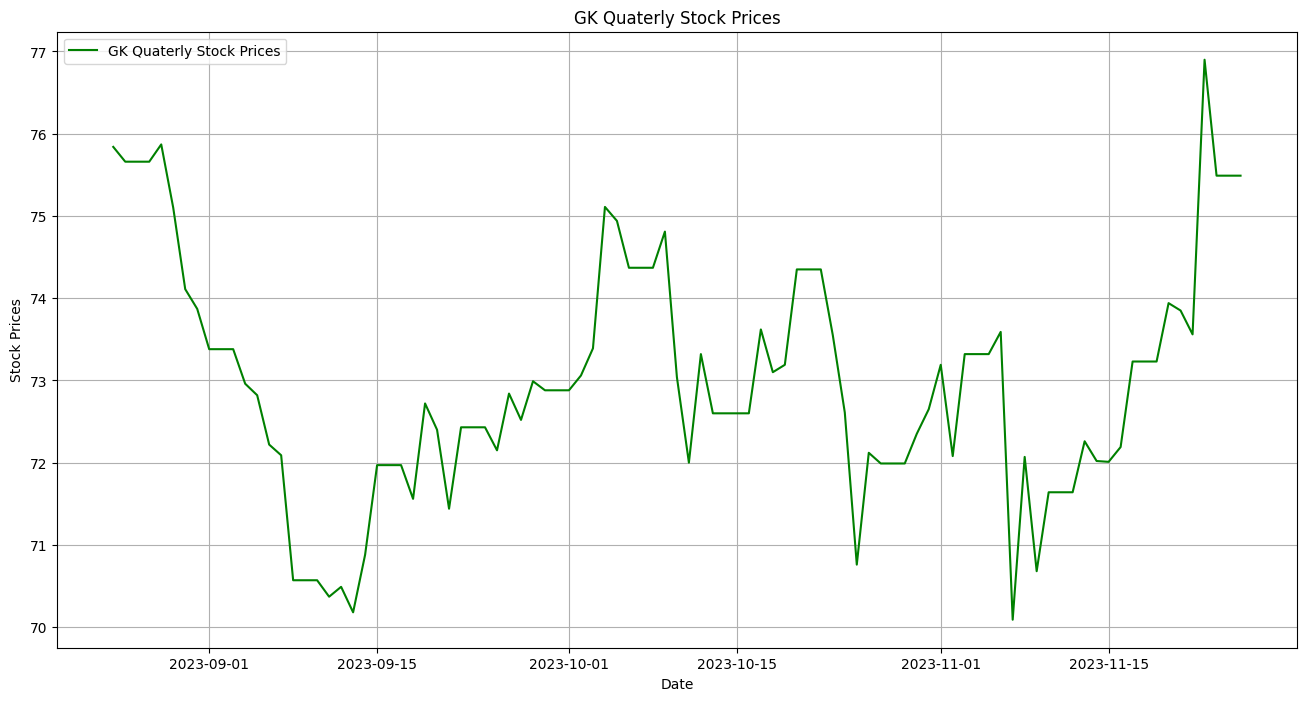

In [8]:
plt.figure(figsize=(16, 8))
plt.plot(df['Closing Price'], label='GK Quaterly Stock Prices', color='green')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Stock Prices')
plt.title('GK Quaterly Stock Prices')
plt.legend()
plt.show()


In [9]:
# Check data for Stationarity using the Augmented Dickey Fuller (ADF) Test
def check_stationarity(df):
    adf_result = adfuller(df)
    return adf_result[1] <= 0.05

# Initializing a counter
differencing_count = 0

# Continuing differencing until the p-value is less than the level of significance
df_diff = df.copy()
while not check_stationarity(df_diff):
    df_diff = df_diff.diff().dropna()


    differencing_count += 1

# Printing the number of differencing iterations
print(f'Number of differencing iterations: {differencing_count}')


Number of differencing iterations: 1


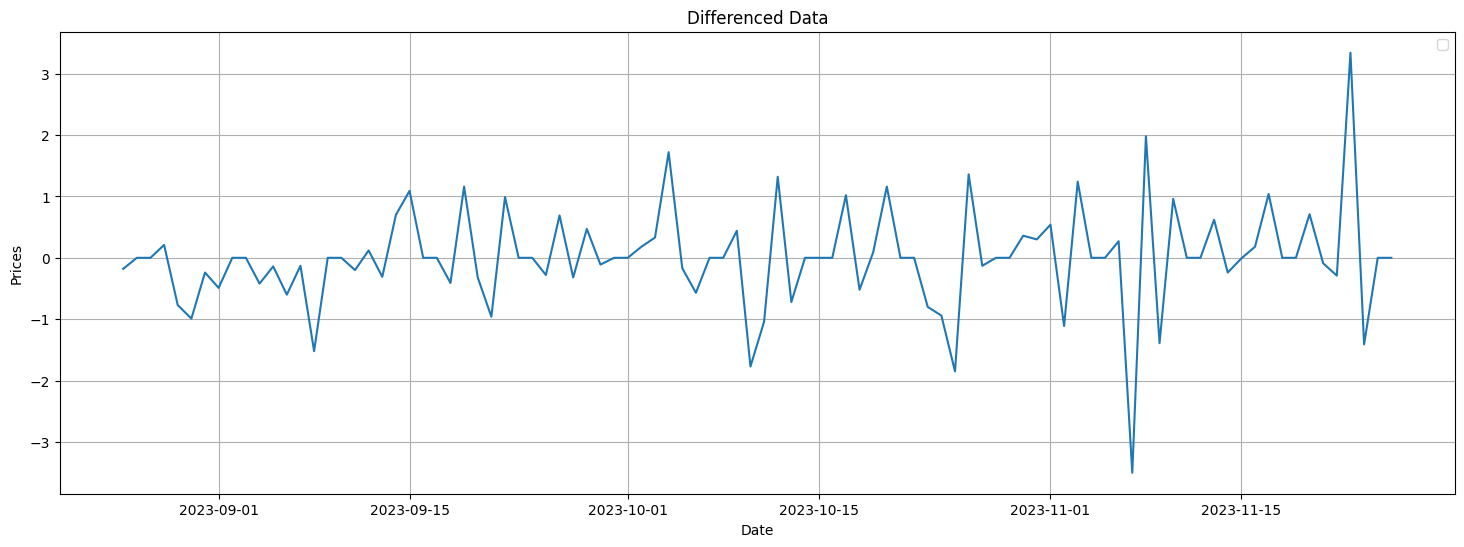

In [10]:
# Plotting the differenced data
plt.figure(figsize=(18,6))
plt.plot(df_diff)
plt.title('Differenced Data')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.grid()
plt.legend()
plt.show()


In [11]:
# Test to check the stationary of the differenced time series
adf_result = adfuller(df_diff)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
# The code shows that the p-value is less than the level of significance (alpha = 0.05).
# This shows that the differenced data is stationary.
# Rule: Accept the Alternative Hypothesis - HA to conclude that there is evidence that the data is stationary.


ADF Statistic: -13.12857918000126
p-value: 1.5111215943905225e-24


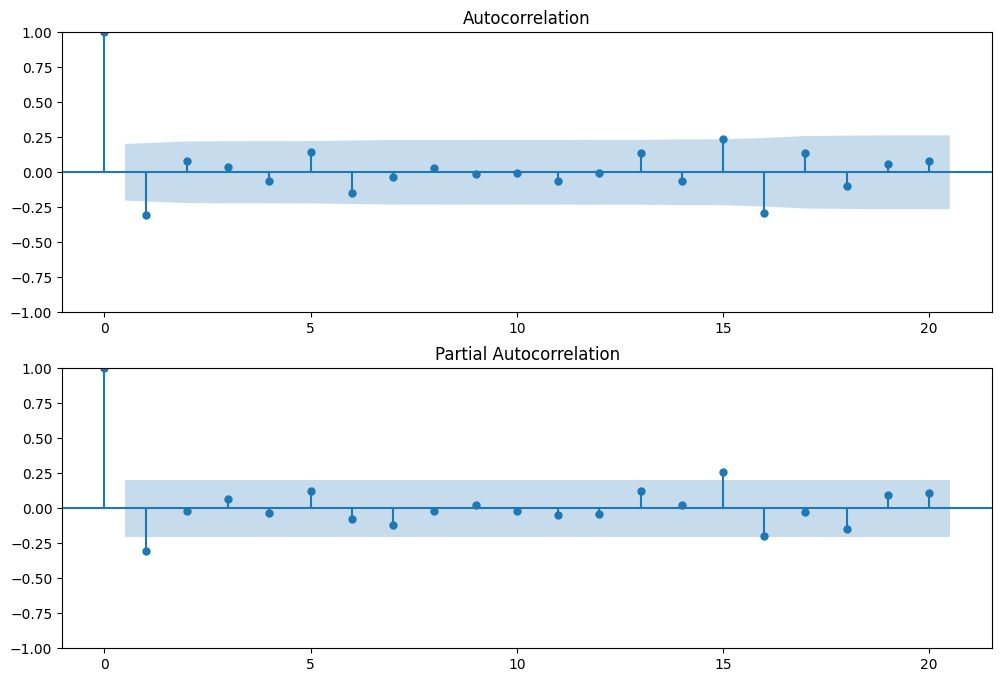

In [12]:
# Determining the AR (AutoRegressive) & MA (Moving Average) parameters using the ACF & PACF.

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,8))
plot_acf(df_diff, lags=20, ax=ax1)
plot_pacf(df_diff, lags=20, ax=ax2)
plt.show()


# ARIMA Model

In [13]:
# Initializing an ARIMA Model
model = ARIMA(df, order=(1, 1, 1))
result = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


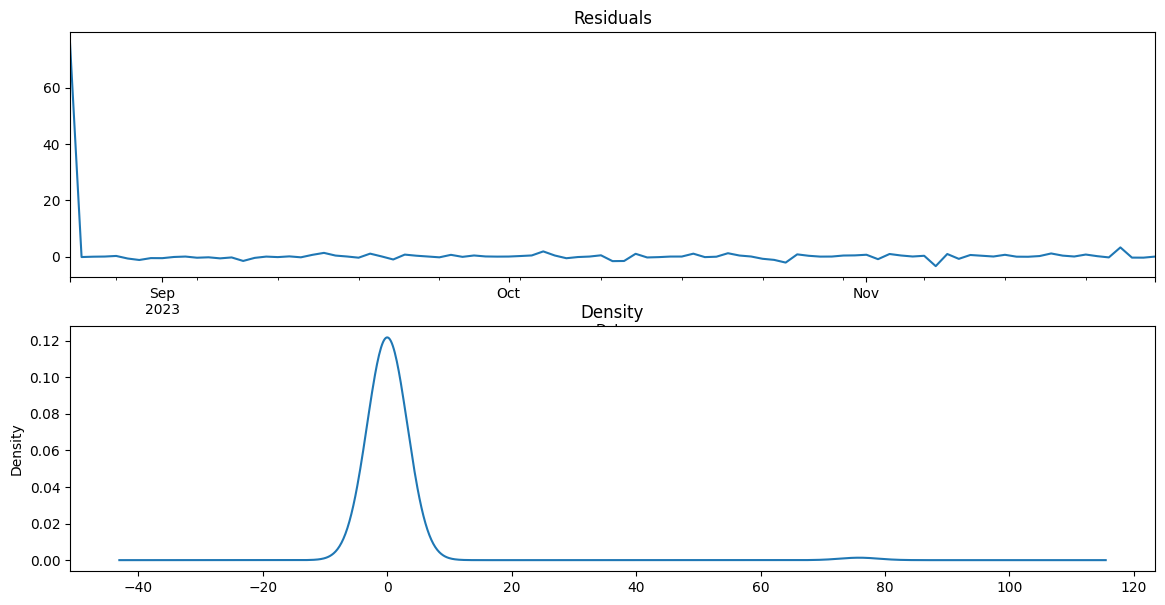

In [14]:
# Plotting the residuals
plt.figure(figsize=(14, 7))
plt.subplot(211)
result.resid.plot(title='Residuals', ax=plt.gca())
plt.subplot(212)
result.resid.plot(kind='kde', title='Density', ax=plt.gca())
plt.show()

<Figure size 1000x500 with 0 Axes>

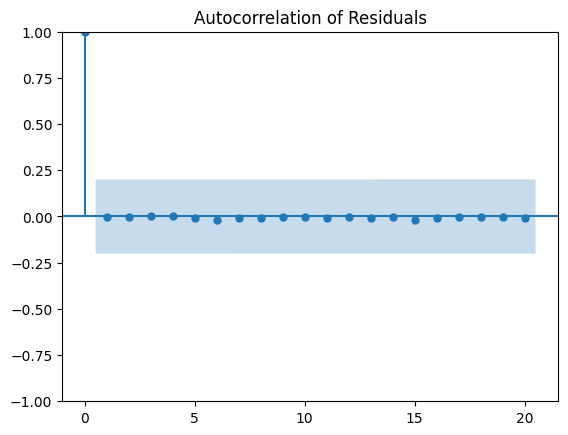

In [15]:
# Plotting the autocorrelation of the residuals to check for any remaining patterns or structures in the data that the model may not have captured
plt.figure(figsize=(10, 5))
plot_acf(result.resid, lags=20)
plt.title('Autocorrelation of Residuals')
plt.show()


In [16]:
# # Forecasting the next 5 steps using an ARIMA model, obtaining predicted mean values and confidence intervals.

forecast_results = result.get_forecast(steps=5)
forecast_mean = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()
# Printing the values
print(forecast_results)
print(forecast_mean)
print(conf_int)


2023-11-27    75.490637
2023-11-28    75.490465
2023-11-29    75.490511
2023-11-30    75.490499
2023-12-01    75.490502
Freq: D, Name: predicted_mean, dtype: float64
            lower Closing Price  upper Closing Price
2023-11-27            73.901287            77.079987
2023-11-28            73.559037            77.421894
2023-11-29            73.200714            77.780309
2023-11-30            72.907979            78.073019
2023-12-01            72.641169            78.339836


In [17]:
import itertools

# Definimg sets of (p, d, q) values for the ARIMA model
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)

# Generating all possible combinations of (p, d, q)
orders = list(itertools.product(p_values, d_values, q_values))

# Initializing a DataFrame to store model evaluation results
results_df = pd.DataFrame(columns=['ORDER', 'AIC', 'BIC', 'MSE'])

# Splitting the data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

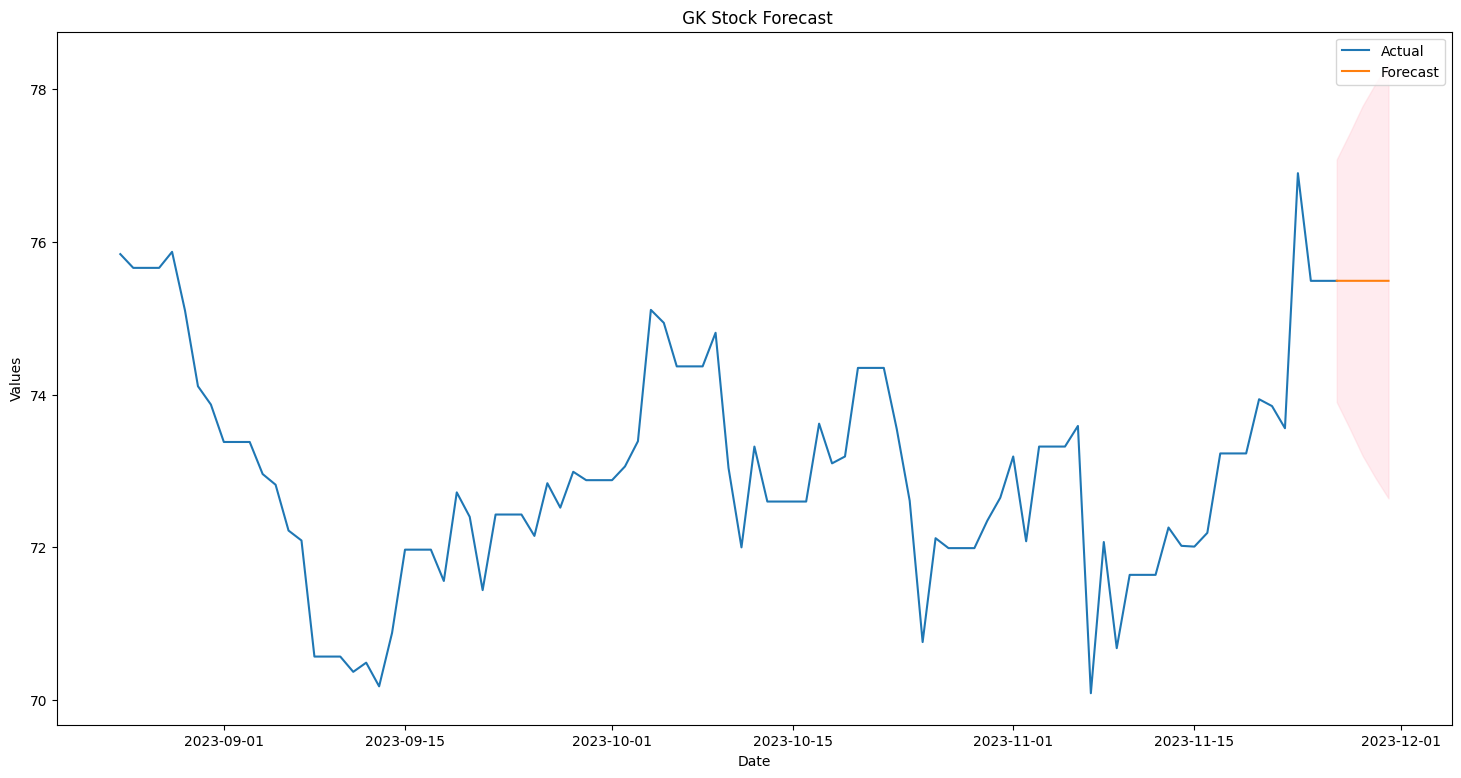

In [18]:
# Generating forecasts and plot results
forecast_results = result.get_forecast(steps=5)
forecast_mean = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

# Plotting actual vs. forecast with their confidence intervals
plt.figure(figsize=(18, 9))
plt.plot(df['Closing Price'], label='Actual')
plt.plot(pd.date_range(start=df.index[-1], periods=5, freq='D'), forecast_mean, label='Forecast')
plt.fill_between(pd.date_range(start=df.index[-1], periods=5, freq='D'), conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title(' GK Stock Forecast')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()


In [19]:
# Fitting the models to compute the AIC, BIC, MSE
for order in orders:
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    aic = model_fit.aic
    bic = model_fit.bic

    # Forecasting the model
    forecast_steps = len(test_data)
    forecast = model_fit.get_forecast(steps=forecast_steps).predicted_mean
    mse = mean_squared_error(test_data, forecast)

    # Storing Results
    results_df = results_df.append({'Order': order, 'AIC': aic, 'BIC': bic, 'MSE': mse}, ignore_index=True)

# Printing the results
print(results_df)



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
<ipython-input-19-39c3e31a1e0a>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Order': order, 'AIC': aic, 'BIC': bic, 'MSE': mse}, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information w

    ORDER         AIC         BIC            MSE      Order
0     NaN  267.982214  272.643680       2.717113  (0, 0, 0)
1     NaN  220.209739  227.201939       2.770397  (0, 0, 1)
2     NaN  206.035046  215.357980       2.478554  (0, 0, 2)
3     NaN  196.327850  207.981517       2.544814  (0, 0, 3)
4     NaN  196.229643  210.214043       2.522093  (0, 0, 4)
..    ...         ...         ...            ...        ...
120   NaN  259.627887  271.011217  245414.476559  (4, 4, 0)
121   NaN  222.624678  236.284674    7103.891454  (4, 4, 1)
122   NaN  210.728860  226.665523     329.874071  (4, 4, 2)
123   NaN  212.571441  230.784770     348.541206  (4, 4, 3)
124   NaN  212.132077  232.622072     793.417221  (4, 4, 4)

[125 rows x 5 columns]


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-19-39c3e31a1e0a>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Order': order, 'AIC': aic, 'BIC': bic, 'MSE': mse}, ignore_index=True)


In [20]:
# Finding the model with the best AIC, BIC and MSE

best_aic_model = results_df.loc[results_df['AIC'].idxmin()]
best_bic_model = results_df.loc[results_df['BIC'].idxmin()]
best_mse_model = results_df.loc[results_df['MSE'].idxmin()]

print(f'The best AIC model : {best_aic_model}')
print(f'The best BIC model : {best_bic_model}')
print(f'The best MSE Model : {best_mse_model}')


The best AIC model : ORDER           NaN
AIC      176.563737
BIC       197.42113
MSE        8.287349
Order     (4, 1, 4)
Name: 109, dtype: object
The best BIC model : ORDER           NaN
AIC      178.616369
BIC      180.933857
MSE       12.233795
Order     (0, 1, 0)
Name: 5, dtype: object
The best MSE Model : ORDER           NaN
AIC      185.973486
BIC      204.619353
MSE        1.238883
Order     (3, 0, 3)
Name: 78, dtype: object


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


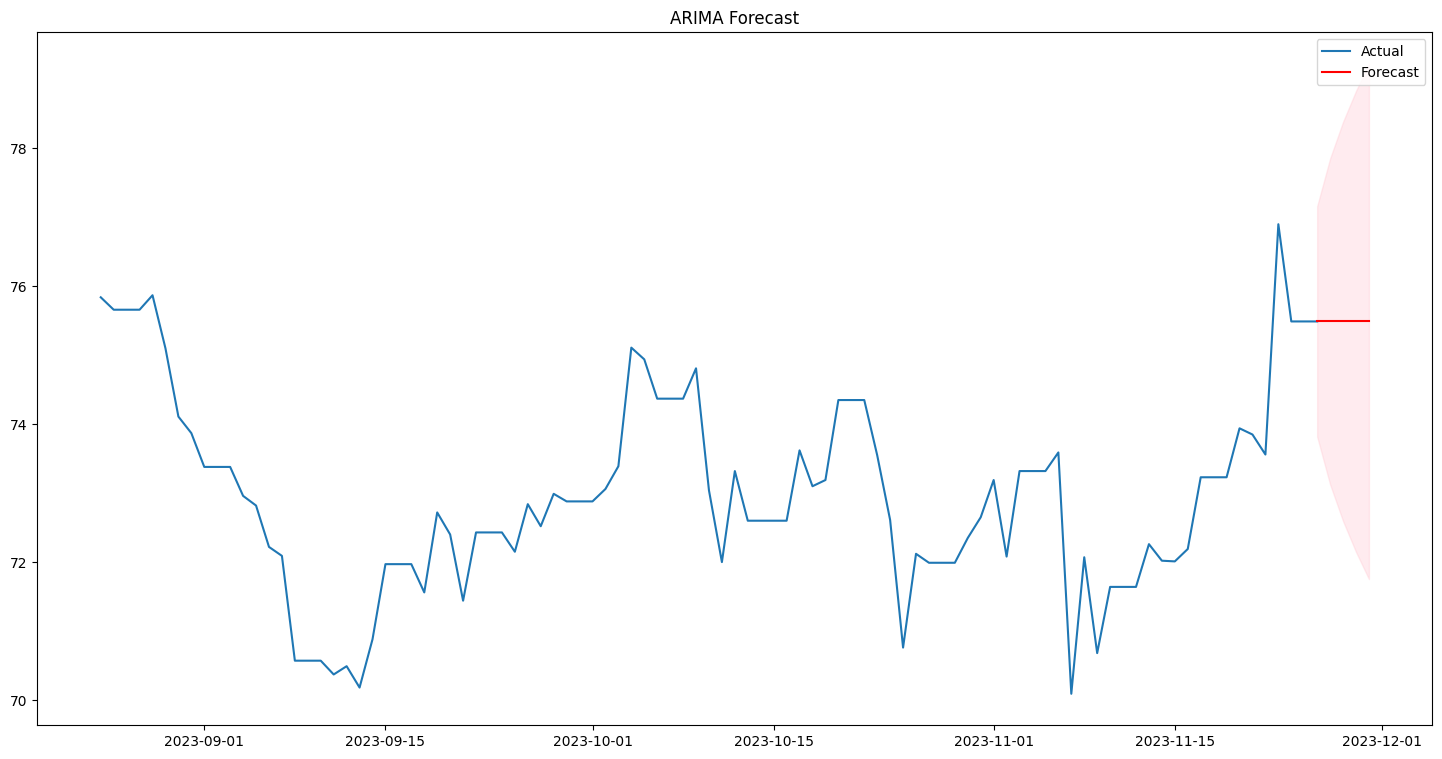

In [21]:
# # Creating a date range for the forecast period based on the last timestamp in the dataset

# Fitting the best model on the training data
best_order = best_bic_model['Order']
best_model= ARIMA(df,order=best_order)
best_model_fit = best_model.fit()

# Forecasting 5 years into the future
forecast_results = best_model_fit.get_forecast(steps=5)
forecast_mean = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

# Creating a new date range for the forecast period
forecast_index = pd.date_range(start=df.index[-1], periods=5, freq='D')

# Assigning the forecast index
forecast_mean.index = forecast_index
conf_int.index = forecast_index

# Plotting the original data and the forecast
plt.figure(figsize=(18,9))
plt.plot(df, label='Actual')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3)

plt.title('ARIMA Forecast')
plt.legend()
plt.show()



In [22]:
# Generating forecasts with the AIC model and printing results
forecast_results2 = best_model_fit.get_forecast(steps=5)
forecast_mean2 = forecast_results2.predicted_mean
conf_int2 = forecast_results2.conf_int()
print(forecast_results2)
print(forecast_mean2)
print(conf_int2)

2023-11-27    75.49
2023-11-28    75.49
2023-11-29    75.49
2023-11-30    75.49
2023-12-01    75.49
Freq: D, Name: predicted_mean, dtype: float64
            lower Closing Price  upper Closing Price
2023-11-27            73.818833            77.161167
2023-11-28            73.126614            77.853386
2023-11-29            72.595455            78.384545
2023-11-30            72.147667            78.832333
2023-12-01            71.753158            79.226842


In [23]:
from tabulate import tabulate
# Evaluating the model on the training set

train_forecast = best_model_fit.get_forecast(steps=len(train_data)).predicted_mean
train_mae = mean_absolute_error(train_data, train_forecast)
train_mse = mean_squared_error(train_data, train_forecast)
train_rmse = np.sqrt(train_mse)

# Evaluating the model on the testing set
forecast_results = best_model_fit.get_forecast(steps=len(test_data))
test_forecast = forecast_results.predicted_mean
test_mae = mean_absolute_error(test_data, test_forecast)
test_mse = mean_squared_error(test_data, test_forecast)
test_rmse = np.sqrt(test_mse)

# Organizing metrics in a tabular form
metrics_table = [
    ["Metric", "Training Set", "Testing Set"],
    ["Mean Absolute Error (MAE)", f"{train_mae:.2f}", f"{test_mae:.2f}"],
    ["Mean Squared Error (MSE)", f"{train_mse:.2f}", f"{test_mse:.2f}"],
    ["Root Mean Squared Error (RMSE)", f"{train_rmse:.2f}", f"{test_rmse:.2f}"],
]

# Printing the tabular form
print(tabulate(metrics_table, headers="firstrow", tablefmt="fancy_grid"))



╒════════════════════════════════╤════════════════╤═══════════════╕
│ Metric                         │   Training Set │   Testing Set │
╞════════════════════════════════╪════════════════╪═══════════════╡
│ Mean Absolute Error (MAE)      │           2.61 │          2.45 │
├────────────────────────────────┼────────────────┼───────────────┤
│ Mean Squared Error (MSE)       │           8.55 │          7.94 │
├────────────────────────────────┼────────────────┼───────────────┤
│ Root Mean Squared Error (RMSE) │           2.92 │          2.82 │
╘════════════════════════════════╧════════════════╧═══════════════╛


In [24]:
# Calculating F1 score for training set
from sklearn.metrics import f1_score
from tabulate import tabulate

# Calculating F1 score for training set
train_directions = np.sign(train_data.diff().dropna())
train_forecast_directions = np.sign(train_forecast.diff().dropna())
train_f1 = f1_score(train_directions, train_forecast_directions, average='weighted')

# Calculating F1 score for testing set
test_directions = np.sign(test_data.diff().dropna())
test_forecast_directions = np.sign(test_forecast.diff().dropna())
test_f1 = f1_score(test_directions, test_forecast_directions, average='weighted')

# Adding F1 score to the metrics table
metrics_table.append(["F1 Score", f"{train_f1:.2f}", f"{test_f1:.2f}"])


In [25]:
# Printing the tabular form
print(tabulate(metrics_table, headers="firstrow", tablefmt="fancy_grid"))


╒════════════════════════════════╤════════════════╤═══════════════╕
│ Metric                         │   Training Set │   Testing Set │
╞════════════════════════════════╪════════════════╪═══════════════╡
│ Mean Absolute Error (MAE)      │           2.61 │          2.45 │
├────────────────────────────────┼────────────────┼───────────────┤
│ Mean Squared Error (MSE)       │           8.55 │          7.94 │
├────────────────────────────────┼────────────────┼───────────────┤
│ Root Mean Squared Error (RMSE) │           2.92 │          2.82 │
├────────────────────────────────┼────────────────┼───────────────┤
│ F1 Score                       │           0.14 │          0.17 │
╘════════════════════════════════╧════════════════╧═══════════════╛
